In [1]:
import os

import pandas as pd
import s3fs
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [3]:
# Lister les challenges
fs.ls("gvimont/diffusion/hackathon-minarm-2024")


['gvimont/diffusion/hackathon-minarm-2024/AIVSAI',
 'gvimont/diffusion/hackathon-minarm-2024/Acoustique',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité']

In [4]:
# Lister les fichiers d'un challenge
fs.ls("gvimont/diffusion/hackathon-minarm-2024/Acoustique")

['gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip']

In [5]:
# Download the data
PATH_IN = 'gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip'
fs.download(PATH_IN, 'data/LivingRoom_preprocessed_hack.zip')

[None]

In [6]:
# Décompresser les données
with zipfile.ZipFile("data/LivingRoom_preprocessed_hack.zip","r") as zip_file:
    zip_file.extractall("data/")

In [7]:
# Chargement des jeux de données de RIR
deconvolved_human1 = np.load('data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy')
deconvolved_human2 = np.load('data/LivingRoom_preprocessed_hack/Human2/deconvoled_trim.npy')
deconvolved_empty = np.load('data/LivingRoom_preprocessed_hack/Empty/deconvolved.npy')

In [8]:
# Calculer les niveaux RMS pour chaque datapoint de chaque micro
niveaux_rms_human1 = []
niveaux_rms_human2 = []
for i in range (4):
    niveaux_rms_h1_i = np.sqrt(np.mean(deconvolved_human1[:,i,:]**2, axis=(1)))
    niveaux_rms_h2_i = np.sqrt(np.mean(deconvolved_human2[:,i,:]**2, axis=(1)))
    niveaux_rms_human1.append(niveaux_rms_h1_i)
    niveaux_rms_human2.append(niveaux_rms_h2_i)

niveaux_rms_human1 = np.array(niveaux_rms_human1)
niveaux_rms_human2 = np.array(niveaux_rms_human2)

# Vérifier les dimensions de niveaux_rms
print("Dimensions des données originales du 1er humain: ", deconvolved_human1.shape)
print("Dimensions de niveaux_rms du 1er humain:", niveaux_rms_human1.shape)
print("Dimensions des données originales du 2eme humain: ", deconvolved_human2.shape)
print("Dimensions de niveaux_rms du 2eme humain:", niveaux_rms_human2.shape)

Dimensions des données originales du 1er humain:  (1000, 4, 667200)
Dimensions de niveaux_rms du 1er humain: (4, 1000)
Dimensions des données originales du 2eme humain:  (104, 4, 667200)
Dimensions de niveaux_rms du 2eme humain: (4, 104)


In [9]:
# Chargement des jeux de données de positions
centroid_human1 = np.load('data/LivingRoom_preprocessed_hack/Human1/centroid.npy')
centroid_human2 = np.load('data/LivingRoom_preprocessed_hack/Human2/centroid.npy')

In [10]:
# Vérification des shapes des données récupérées
print(centroid_human1.shape)
print(centroid_human2.shape)

(1000, 2)
(104, 2)


In [11]:
# Mise en commun de human1 et human2 en un seul jeu de donnée pour les RMS et les positions
niveaux_rms = np.concatenate((niveaux_rms_human1, niveaux_rms_human2), axis=1)

# on transpose les arrays avec .T pour éviter les conflits pendant la mise en commun,
# puis on retranspose derrière
positions = np.concatenate((centroid_human1.T, centroid_human2.T), axis=1)
positions = positions.T

#vérification des shapes de la mise en commun
print(niveaux_rms.shape)
print(positions.shape)

(4, 1104)
(1104, 2)


In [12]:
# Préparation des données pour l'entrainement

# X : données de niveaux RMS (4, N_datapoints)
# y : données de position (N_datapoints, 2)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(niveaux_rms.T, positions, test_size=0.2, random_state=42)


## Algorithmes utilisés:
 - KNN
 - Linear Regression
 - Naive Bayes
 - SVM
 - RNN


In [13]:
# Implémentation de KNN

# Choix des voisins: 4, car c'est celui qui minimise la distance moyenne
knn = KNeighborsRegressor(n_neighbors=4)

# Entrainement
knn.fit(X_train, y_train)

# Prediction des positions
predictions = knn.predict(X_test)

# Evaluation (moyenne de la distance des prédictions par rapport aux distances réelles)
knn_eval = np.mean(np.abs(y_test - predictions))
print("KNN average distance from real position :", knn_eval, " mm")

KNN average distance from real position : 623.9663822906018  mm


In [14]:
# Create a linear regression model
linear_regression = LinearRegression()

# Train the linear regression model
linear_regression.fit(X_train, y_train)

# Predict positions for test data
predictions = linear_regression.predict(X_test)

# Evaluation (moyenne de la distance des prédictions par rapport aux distances réelles)
lr_eval = np.mean(np.abs(y_test - predictions))
print("Linear Regression average distance from real position:", lr_eval, " mm")

Linear Regression average distance from real position: 959.3142318123437  mm


In [15]:
# Create a RNN model (REQUIRES TENSORFLOW)
# import tensorflow as tf
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=32, input_length=max_sequence_length),
#     tf.keras.layers.SimpleRNN(32),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

In [16]:
# Microphone Locations
mic_height = 50.3125
feet = 12
y_tile = 23.5
x_tile = 11 +7/8

camera_origin_location = np.array([-6*x_tile-5.75, -y_tile, 45+13/16])*25.4

mic_1 = np.array([-11*x_tile - 1, -5*y_tile - 6-3/8, mic_height]) * 25.4 
mic_4= np.array([-11*x_tile + 1.25 + 1/16, 2.5*y_tile+3.75, mic_height]) * 25.4
mic_6 = np.array([5+3/8, 2+1/8, mic_height]) * 25.4
mic_9 = np.array([-3, -6*y_tile - 0.5, mic_height]) * 25.4


mic_xyzs = np.stack((mic_1,mic_4, mic_6, mic_9),axis=0)

SPEAKER_BOTTOM_RIGHT_Y = (1200.15 + 1196.975 + 1206.5)/ 3
SPEAKER_BOTTOM_RIGHT_X = (88.9 + 107.95 + 101.6) / 3
SPEAKER_BOTTOM_LEFT_Y = (1327.15 + 1311.55712764 + 1317.625) / 3
SPEAKER_BOTTOM_LEFT_X = - 76.98583188

speaker_xyz_bottom_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, 44.5*25.4])
speaker_xyz_bottom_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, 44.5*25.4])
speaker_xyz_top_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, (44.5+17)*25.4])
speaker_xyz_top_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, (44.5+17)*25.4])
speaker_xyz = (speaker_xyz_bottom_right+speaker_xyz_bottom_left+speaker_xyz_top_right+speaker_xyz_top_left)/4


walls = None
x_min = - 4000
x_max = 500
y_min = -4000
y_max = 2000


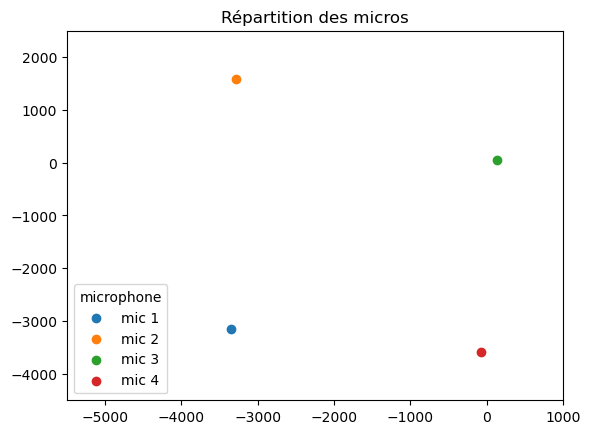

In [17]:
## affichier la disposition des microphones.
for idx, mic in enumerate(mic_xyzs):
    plt.scatter(mic[0], mic[1], label=f'mic {idx+1}')

plt.title("Répartition des micros")
plt.xlim([-5500, 1000])
plt.ylim([-4500, 2500])
plt.legend(loc="lower left", title="microphone")

In [18]:
from sklearn.preprocessing import StandardScaler

# Normalize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [19]:
import tensorflow as tf


# Reconvertir en image

# Define the CNN architecture
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((4, 1), input_shape=(4,)),  # Reshape for 1D convolution
    tf.keras.layers.Conv1D(64, kernel_size=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)  # Output layer for predicting x, y coordinates
])

# Compile the model
model.compile(optimizer='adam', loss='mse')


2024-04-24 09:12:32.145379: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 09:12:32.150984: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 09:12:32.207460: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 09:12:32.930695: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/mamba/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  

In [24]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=10)


Epoch 1/50


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1518142.2500 - val_loss: 1524869.6250
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1534873.1250 - val_loss: 1528350.0000
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1560453.5000 - val_loss: 1528256.0000
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1541280.2500 - val_loss: 1524356.3750
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1568697.8750 - val_loss: 1526553.1250
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1593008.1250 - val_loss: 1525326.1250
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1574418.2500 - val_loss: 1522212.7500
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1538753.2500 - val_loss: 1525080.0000
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1503472.3750 - val_loss: 1526544.2500
Epoch 10/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1534938.8750 - val_loss: 1523607.5000
Epoch 11/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

In [25]:
# Evaluate the model on the test set
#test_loss = model.evaluate(X_test_scaled, y_test)
#print("Test loss (MSE):", test_loss)

from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate predictions
predictions = model.predict(X_test)

# Calculate Euclidean distance between the predicted and actual positions
errors = np.sqrt(np.sum((y_test - predictions)**2, axis=1))
average_error = np.mean(errors)

print("Average Euclidean distance from actual positions: {:.2f} mm".format(average_error))



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Average Euclidean distance from actual positions: 1633.40 mm


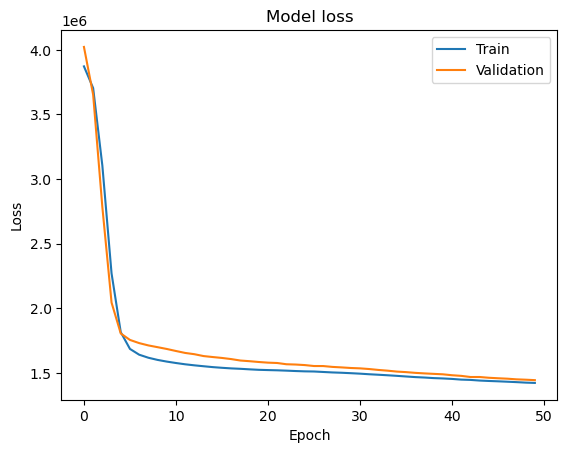

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()